# Install Dependencies

In [ ]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib tensorflowjs

In [ ]:
!pip install pillow

In [ ]:
!pip install pillow python-bidi arabic-reshaper

In [1]:
import os
import numpy as np
import cv2
import mediapipe as mp
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    return results

# Extract Keypoint Values

In [4]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)
    return np.concatenate([lh, rh])

# Setup Folders for Collection

In [5]:
# Path for exported data, numpy arrays
DATA_PATH = "C:\\Users\\WinDOWS\\Desktop\\University\\ArSL\\actions1"

# Actions to detect
ACTIONS = np.array(['yes', 'assalamu_alaikum', 'how_are_you', 'alhamdulelah', 
                    'an_sha_allah', 'please', 'welcome', 'thanks', 'congrats', 'happy'])

# Videos are going to be 50 frames in length
SEQUENCE_LENGTH = 50

#  fifty videos worth of data
NO_SEQUENCES = 50

# Data Augmentation

In [6]:
def augment_keypoints(keypoints):
    # Apply random flip
    flip_prob = np.random.rand()
    if flip_prob > 0.5:
        keypoints[::3] *= -1  # Flip x-coordinates
    
    # Apply small random noise
    keypoints += np.random.normal(0, 0.01, keypoints.shape)
    
    return keypoints

# Data Preprocessing

In [7]:
label_map = {label: num for num, label in enumerate(ACTIONS)}

In [8]:
label_map

{'yes': 0,
 'assalamu_alaikum': 1,
 'how_are_you': 2,
 'alhamdulelah': 3,
 'an_sha_allah': 4,
 'please': 5,
 'welcome': 6,
 'thanks': 7,
 'congrats': 8,
 'happy': 9}

In [9]:
sequences, labels = [], []

for action in ACTIONS:
    for sequence in os.listdir(os.path.join(DATA_PATH, action)):
        window = []
        for frame_num in range(SEQUENCE_LENGTH):
            keypoints = np.load(os.path.join(DATA_PATH, action, sequence, f"{frame_num}.npy"))
            augmented_keypoints = augment_keypoints(keypoints)
            window.append(augmented_keypoints)
        sequences.append(window)
        labels.append(label_map[action])

In [10]:
X = np.array(sequences)

In [11]:
y = to_categorical(labels).astype(int)

**Spliting Data into 80% train, 10% validation, 10% test**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Build and Train LSTM Neural Network

In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [60]:
model = models.Sequential([
    # Bidirectional LSTM layer to capture both past and future dependencies
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(SEQUENCE_LENGTH, 126)),
    
    # Another Bidirectional LSTM layer to capture deeper temporal patterns
    layers.Bidirectional(layers.LSTM(128)),
    
    # Dropout for regularization
    layers.Dropout(0.3),
    
    # Adding a Dense layer with a different activation function (e.g., LeakyReLU)
    layers.Dense(128),
    layers.LeakyReLU(alpha=0.1),
    
    # Optionally, use Batch Normalization to stabilize training
    layers.BatchNormalization(),
    
    # Output layer
    layers.Dense(len(ACTIONS), activation='softmax')
])


In [61]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 50, 256)           261120    
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 128)              

In [62]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

In [64]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32, callbacks=[early_stop])

Epoch 1/300
10/10 [==============================] - 8s 260ms/step - loss: 2.0444 - accuracy: 0.2688 - val_loss: 2.1194 - val_accuracy: 0.2000
Epoch 2/300
10/10 [==============================] - 1s 93ms/step - loss: 1.4887 - accuracy: 0.4062 - val_loss: 1.9132 - val_accuracy: 0.3625
Epoch 3/300
10/10 [==============================] - 1s 91ms/step - loss: 1.0440 - accuracy: 0.5562 - val_loss: 1.6647 - val_accuracy: 0.5000
Epoch 4/300
10/10 [==============================] - 1s 94ms/step - loss: 0.7378 - accuracy: 0.7312 - val_loss: 1.4805 - val_accuracy: 0.6625
Epoch 5/300
10/10 [==============================] - 1s 93ms/step - loss: 0.6072 - accuracy: 0.8031 - val_loss: 1.3734 - val_accuracy: 0.7375
Epoch 6/300
10/10 [==============================] - 1s 96ms/step - loss: 0.4512 - accuracy: 0.8375 - val_loss: 1.1406 - val_accuracy: 0.8375
Epoch 7/300
10/10 [==============================] - 1s 104ms/step - loss: 0.2791 - accuracy: 0.9281 - val_loss: 1.1894 - val_accuracy: 0.6875
Epoc

In [65]:
model.save('C:\\Users\\WinDOWS\\Desktop\\University\\ArSL\\simple_lstm_2_action.h5')

c:\Users\WinDOWS\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


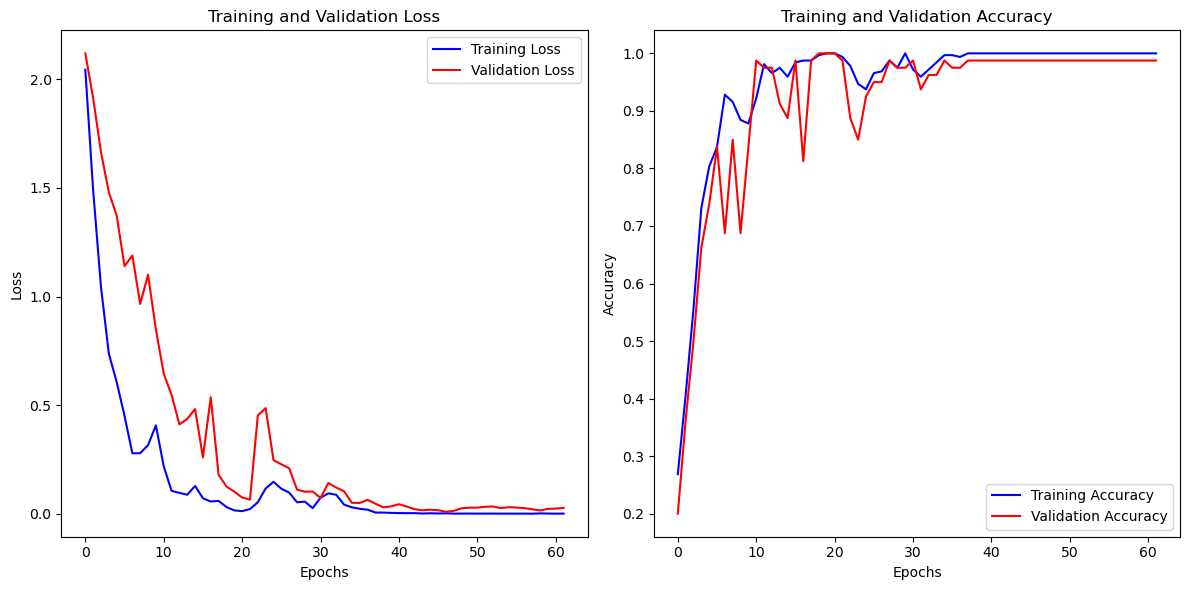

In [66]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Make Predictions

In [67]:
res = model.predict(X_test)

4/4 [==============================] - 2s 25ms/step


In [69]:
ACTIONS[np.argmax(res[3])]

'سعيد'

In [70]:
ACTIONS[np.argmax(y_test[3])]

'سعيد'

# LSTM Evaluation

In [71]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

misclassified_indices = np.where(y_pred_classes != y_true)[0]
print(f"Misclassified Indices: {misclassified_indices}")


4/4 [==============================] - 0s 23ms/step
Misclassified Indices: []


In [72]:
y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1) 

4/4 [==============================] - 0s 29ms/step


In [73]:
y_true = np.argmax(y_test, axis=1)

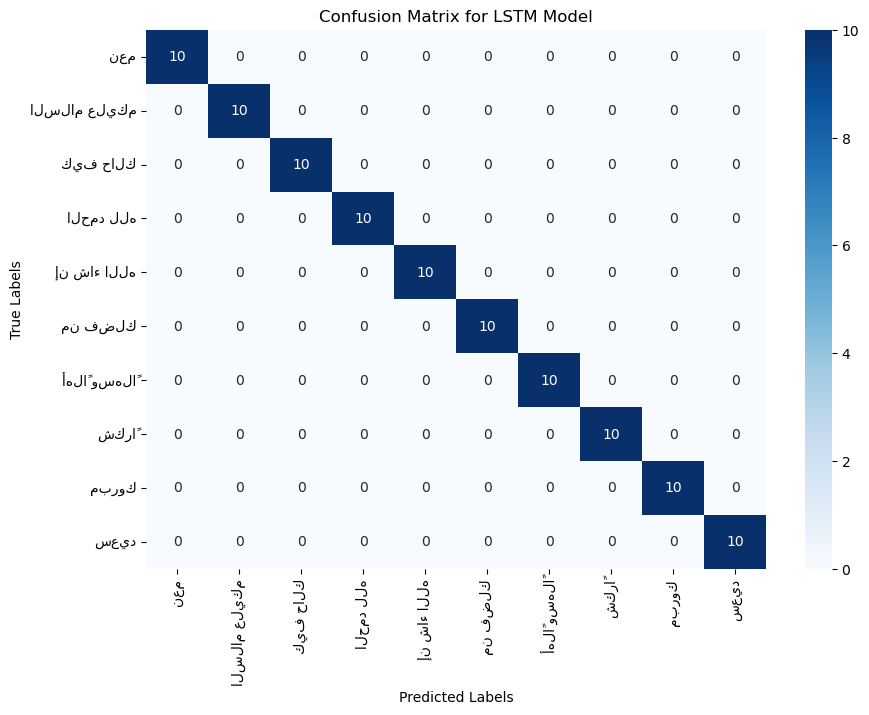

In [74]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIONS, yticklabels=ACTIONS)  # actions is your list of labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [75]:
print("Classification Report:")
print(classification_report(y_true, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



# LSTM Realtime Test

In [98]:
from tensorflow.keras.models import load_model
from PIL import ImageFont, ImageDraw, Image
import arabic_reshaper
from bidi.algorithm import get_display

# Load the model
model = load_model('C:\\Users\\WinDOWS\\Desktop\\University\\ArSL\\simple_lstm_2_action.h5')

# Font path for displaying Arabic text
font_path = "C:\\Users\\WinDOWS\\Desktop\\University\\ArSL\\Arial_Bold.ttf"
font = ImageFont.truetype(font_path, 32)

# Define actions (Arabic labels)
ACTIONS = ['نعم', 'السلام عليكم', 'كيف حالك', 'الحمد لله', 'إن شاء الله', 'من فضلك', 'أهلاً وسهلاً', 'شكراً', 'مبروك', 'سعيد']

# Function to draw Arabic text on the image
def draw_text_on_image(image, text, font, position=(10, 50)):
    # Reshape the Arabic text for correct display
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    
    # Convert OpenCV image to PIL format
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)
    
    # Draw the Arabic text on the image
    draw.text(position, bidi_text, font=font, fill=(255, 0, 0))  # Red color for the text
    
    # Convert back to OpenCV format
    return cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

# Initialize video capture (webcam)
cap = cv2.VideoCapture(0)

# Sequence length for gesture prediction
SEQUENCE_LENGTH = 50  # Adjust based on your model's input size

# MediaPipe Holistic for hand and pose detection
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    sequence = []  # List to hold keypoints
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections using MediaPipe Holistic
        results = mediapipe_detection(frame, holistic)
        
        # Extract keypoints from the detected landmarks
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Keep the sequence within the maximum length
        if len(sequence) > SEQUENCE_LENGTH:
            sequence = sequence[-SEQUENCE_LENGTH:]

        # Predict the action if the sequence length is met
        if len(sequence) == SEQUENCE_LENGTH:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Display the action if confidence is above threshold (e.g., 0.5)
            if res[np.argmax(res)] > 0.5:
                action = ACTIONS[np.argmax(res)]
                frame = draw_text_on_image(frame, action, font)  # Draw the predicted Arabic label on the frame

        # Show the frame with the Arabic text
        cv2.imshow('Real-Time Sign Language Detection', frame)
        
        # Exit gracefully if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 33ms/step


 # Build and train GRU Model 

In [79]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
model_gru = models.Sequential([
    # Bidirectional GRU layer to capture both past and future dependencies
    layers.Bidirectional(layers.GRU(128, return_sequences=True), input_shape=(SEQUENCE_LENGTH, 126)),
    
    # Another Bidirectional GRU layer to capture deeper temporal patterns
    layers.Bidirectional(layers.GRU(128)),
    
    # Dropout for regularization
    layers.Dropout(0.3),
    
    # Adding a Dense layer with a different activation function (e.g., LeakyReLU)
    layers.Dense(128),
    layers.LeakyReLU(alpha=0.1),
    
    # Optionally, use Batch Normalization to stabilize training
    layers.BatchNormalization(),
    
    # Output layer
    layers.Dense(len(ACTIONS), activation='softmax')
])

In [87]:
model_gru.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 50, 256)           196608    
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 256)               296448    
 ional)                                                          
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 128)             

In [84]:
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
early_stopping_gru = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

In [86]:
history1 = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32, callbacks=[early_stop])

Epoch 1/300
10/10 [==============================] - 8s 207ms/step - loss: 2.2754 - accuracy: 0.1969 - val_loss: 2.2562 - val_accuracy: 0.1125
Epoch 2/300
10/10 [==============================] - 1s 78ms/step - loss: 1.6360 - accuracy: 0.3812 - val_loss: 2.2068 - val_accuracy: 0.1250
Epoch 3/300
10/10 [==============================] - 1s 70ms/step - loss: 1.3497 - accuracy: 0.5125 - val_loss: 1.9624 - val_accuracy: 0.2500
Epoch 4/300
10/10 [==============================] - 1s 71ms/step - loss: 1.0948 - accuracy: 0.6000 - val_loss: 1.7156 - val_accuracy: 0.3875
Epoch 5/300
10/10 [==============================] - 1s 71ms/step - loss: 0.8531 - accuracy: 0.6781 - val_loss: 1.5393 - val_accuracy: 0.5625
Epoch 6/300
10/10 [==============================] - 1s 71ms/step - loss: 0.6963 - accuracy: 0.7625 - val_loss: 1.3871 - val_accuracy: 0.7000
Epoch 7/300
10/10 [==============================] - 1s 70ms/step - loss: 0.5548 - accuracy: 0.7875 - val_loss: 1.2559 - val_accuracy: 0.7750
Epoch

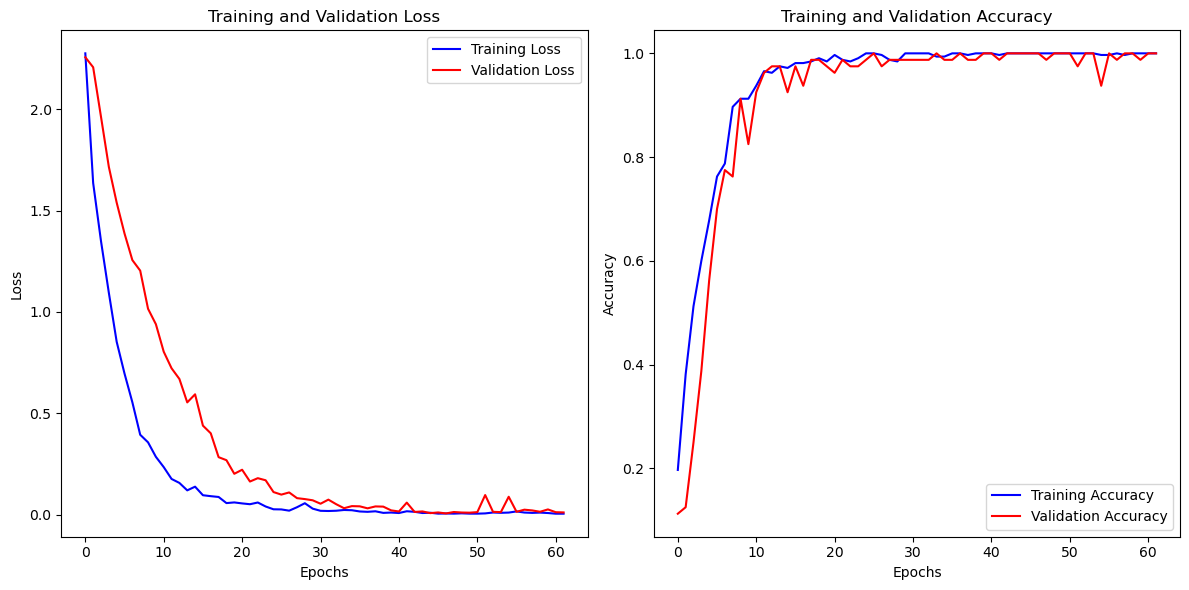

In [88]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss', color='blue')
plt.plot(history1.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [89]:
model_gru.save("C:\\Users\\WinDOWS\\Desktop\\University\\ArSL\\simple_gru_2_action.h5")

c:\Users\WinDOWS\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# GRU Evaluation

In [90]:
# Make predictions
y_pred = model_gru.predict(X_test)

# Convert predictions to class labels
y_pred_classes1 = np.argmax(y_pred, axis=1)

4/4 [==============================] - 2s 27ms/step


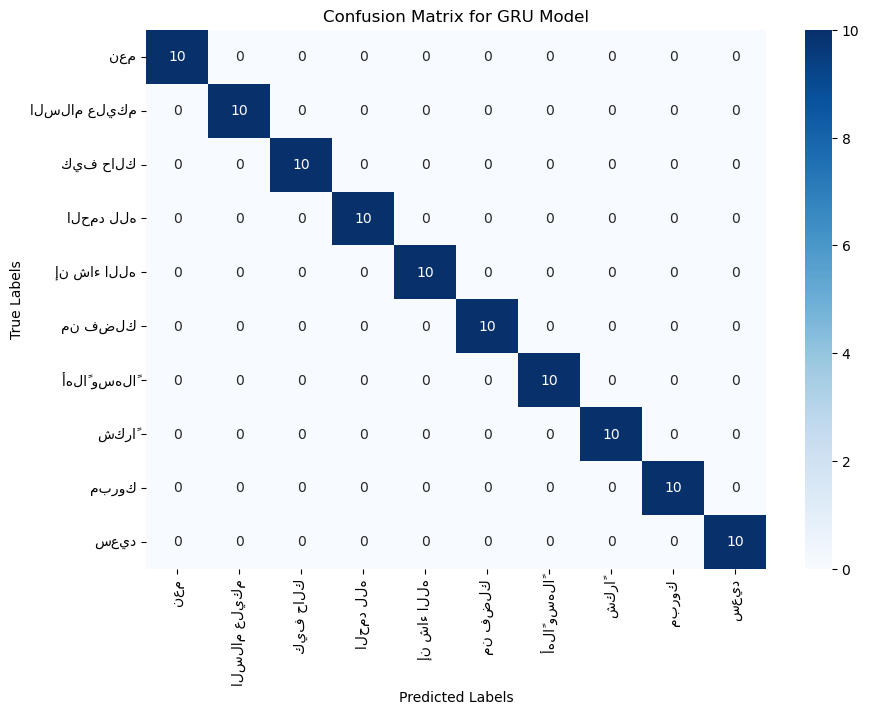

In [92]:
cm = confusion_matrix(y_true, y_pred_classes1)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIONS, yticklabels=ACTIONS) 
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for GRU Model')
plt.show()


In [93]:
print("Classification Report:")
print(classification_report(y_true, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:
from tensorflow.keras.models import load_model
from PIL import ImageFont, ImageDraw, Image
import arabic_reshaper
from bidi.algorithm import get_display

# Load the model
model2 = load_model('C:\\Users\\WinDOWS\\Desktop\\University\\ArSL\\simple_gru_2_action.h5')

# Font path for displaying Arabic text
font_path = "C:\\Users\\WinDOWS\\Desktop\\University\\ArSL\\Arial_Bold.ttf"
font = ImageFont.truetype(font_path, 32)

# Define actions (Arabic labels)
ACTIONS = ['نعم', 'السلام عليكم', 'كيف حالك', 'الحمد لله', 'إن شاء الله', 'من فضلك', 'أهلاً وسهلاً', 'شكراً', 'مبروك', 'سعيد']

# Function to draw Arabic text on the image
def draw_text_on_image(image, text, font, position=(10, 50)):
    # Reshape the Arabic text for correct display
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    
    # Convert OpenCV image to PIL format
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(image_pil)
    
    # Draw the Arabic text on the image
    draw.text(position, bidi_text, font=font, fill=(255, 0, 0))  # Red color for the text
    
    # Convert back to OpenCV format
    return cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

# Initialize video capture (webcam)
cap = cv2.VideoCapture(0)

# Sequence length for gesture prediction
SEQUENCE_LENGTH = 50 

# MediaPipe Holistic for hand and pose detection
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    sequence = []  # List to hold keypoints
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections using MediaPipe Holistic
        results = mediapipe_detection(frame, holistic)
        
        # Extract keypoints from the detected landmarks
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Keep the sequence within the maximum length
        if len(sequence) > SEQUENCE_LENGTH:
            sequence = sequence[-SEQUENCE_LENGTH:]

        # Predict the action if the sequence length is met
        if len(sequence) == SEQUENCE_LENGTH:
            res = model2.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Display the action if confidence is above threshold 
            if res[np.argmax(res)] > 0.5:
                action = ACTIONS[np.argmax(res)]
                frame = draw_text_on_image(frame, action, font)  # Draw the predicted Arabic label on the frame

        # Show the frame with the Arabic text
        cv2.imshow('Real-Time Sign Language Detection', frame)
        
        # Exit gracefully if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
cv2.destroyAllWindows()


c:\Users\WinDOWS\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 28ms/step
